In [1]:
import nest_asyncio
nest_asyncio.apply()

from langchain.agents import Tool
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from typing import TypedDict, List, Tuple, Union, Annotated
import operator
from langgraph.graph import StateGraph, START, END

import pickle


In [2]:
with open(r"C:\Users\info\Desktop\harlus\server\data\AAPL\thesis_source_document_pdf\tools\doc_search\tool.pkl", "rb") as file:
    qengine_ths = pickle.load(file).tool.query_engine
with open(r"C:\Users\info\Desktop\harlus\server\data\AAPL\Earnings_Call_Q2_2025_pdf\tools\doc_search\tool.pkl", "rb") as file:
    qengine_evd = pickle.load(file).tool.query_engine

tool_ths = Tool(
    name="tool_thesis",
    func=lambda query: str(qengine_ths.query(query)),
    description="Old document explaining the investment case, i.e. the predictions for a stock."
)
tool_evd = Tool(
    name="tool_evidence",
    func=lambda query: str(qengine_evd.query(query)),
    description="New document with recent data on a stock."
)
tools = [tool_ths, tool_evd]

# --- Create the execution agent ---
llm = ChatOpenAI(model="o3-mini")
agent_executor = create_react_agent(
    llm,
    tools,
    prompt="You are a financial analysis assistant. Execute each step carefully, querying the appropriate tool."
)

# --- Define the state schema ---
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple[str, str]], operator.add]
    response: str

# --- Structured types for planning & replanning ---
class Plan(BaseModel):
    steps: List[str] = Field(description="Steps to extract and compare claims")

class Response(BaseModel):
    response: str

class Act(BaseModel):
    action: Union[Plan, Response] = Field(
        description="Plan to continue or Response to finish"
    )

# --- Prompts for planner and replanner ---
planner_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
"""\
You are a senior financial analyst specializing in equity research. Your task is to perform a contrastive investment thesis analysis based on two financial documents:
1. Thesis Source Document: typically an investor memo, prior analysis, or strategic review.
2. Earnings Document: typically a quarterly or annual earnings report or earnings call.

This task involves three high-level steps:

# Step 1: Extract Investment Theses

From the first document, extract all distinct investment theses. Each thesis should represent a clear, concise, and reasoned hypothesis about why an investment is expected to generate positive returns. A good thesis typically includes:
- A strategic rationale or competitive advantage.
- A market or financial performance expectation.
- A causal relationship between an observable factor and expected investment return.
Do not include vague or generic statements. Only extract well-formed, specific hypotheses.
A thesis can be a qualitative or quantitative statement about company KPIs or market characteristics. Thus, projections, outlooks, expectations are also valid theses.

# Step 2: Validate Theses Against Earnings Document

For each thesis extracted:
- Analyze the second document (earnings report) for any evidence that supports (validates) or contradicts (refutes) the thesis.
- If no information is found relevant to the thesis, explicitly state this (do not speculate or infer).

# Step 3: Classify claims into true, false, or unknown.

- "true": The earnings document provides clear support for the thesis.
- "false": The earnings document contradicts or undermines the thesis.
- "unknown": The thesis is not addressed in the earnings document.

Create a detailed step-by-step plan to perform the above analysis.
You do not need to follow the order of steps strictly, but make sure you cover all the steps.

You are given two tools, one query engine for the thesis source document and another query engine for the earnings document.
These query engines can answer basic questions about the document. They have limited abilities. 
So the steps of your plan should be as simple and precise as possible. As if you are asking questions to an intern.

Return only the ordered list of steps.
""",
    ),
    ("placeholder", "{messages}")
])
planner = planner_prompt | llm.with_structured_output(Plan)

replanner_prompt = ChatPromptTemplate.from_template(
    """
Your objective: {input}
Original plan: {plan}
Past steps and results: {past_steps}
If the plan is complete, return a Response with the final answer. Otherwise return a new Plan of remaining steps.
"""
)
replanner = replanner_prompt | llm.with_structured_output(Act)

# --- Define graph step functions ---
async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"]) ]})
    return {"plan": plan.steps}

async def execute_step(state: PlanExecute):
    # Execute the next step using the React agent
    task = state["plan"][0]
    result = await agent_executor.ainvoke({"messages": [("user", task)]})
    content = result["messages"][-1].content
    return {"past_steps": [(task, content)]}

async def replan_step(state: PlanExecute):
    act = await replanner.ainvoke(state)
    if isinstance(act.action, Response):
        return {"response": act.action.response}
    else:
        return {"plan": act.action.steps}

def should_end(state: PlanExecute):
    return END if state.get("response") else "agent"

# --- Build and compile the graph ---
workflow = StateGraph(PlanExecute)
workflow.add_node("planner", plan_step)
workflow.add_node("agent", execute_step)
workflow.add_node("replan", replan_step)
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "agent")
workflow.add_edge("agent", "replan")
workflow.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END],
)
app = workflow.compile()

c:\Users\info\Desktop\harlus\python\env\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
user_prompt = (
    "Compare the two financial documents."
    " Extract and classify claims as confirmed, contradicted, or not discussed,"
    " and list new value drivers from the second document."
)
result = await app.ainvoke({"input": user_prompt}, debug=True)
print(result["response"])

[-1:checkpoint] State at the end of step -1:
{'past_steps': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input': 'Compare the two financial documents. Extract and classify claims as '
          'confirmed, contradicted, or not discussed, and list new value '
          'drivers from the second document.'}
[0:writes] Finished step 0 with writes to 1 channel:
- input -> ('Compare the two financial documents. Extract and classify claims as '
 'confirmed, contradicted, or not discussed, and list new value drivers from '
 'the second document.')
[0:checkpoint] State at the end of step 0:
{'input': 'Compare the two financial documents. Extract and classify claims as '
          'confirmed, contradicted, or not discussed, and list new value '
          'drivers from the second document.',
 'past_steps': []}
[1:tasks] Starting 1 task for step 1:
- planner -> {'input': 'Compare the two financial documents. Extract and classify claims as '
          'confirmed, contradicted, or not 

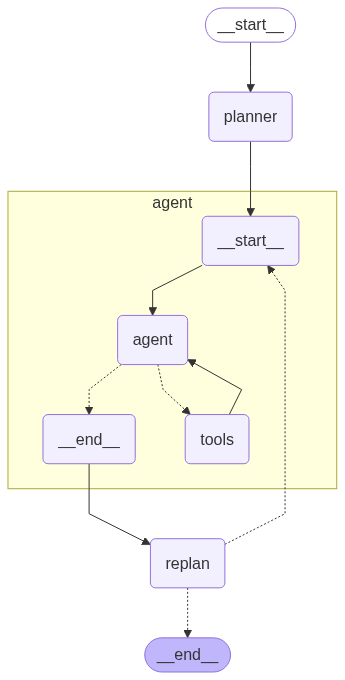

In [4]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))